In [250]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time
import random
import collections
from matplotlib import colors

import mdptoolbox.mdp as mdp
import mdptoolbox.example
from hiive.mdptoolbox import mdp as hmdp

%config Completer.use_jedi = False

import warnings
warnings.filterwarnings('ignore')

import gym
from gym.envs.toy_text.frozen_lake import generate_random_map

## Helpers

In [338]:
def get_frozen_lake(name, is_random=False):
    if is_random:
        np.random.seed(12345678)
        flsz = 8
        flrmap = generate_random_map(size=flsz, p=0.82)
        env = gym.make(name, desc=flrmap, is_slippery = True)
    else:
        env = gym.make(name)
    
#     nA, nS = env.nA, env.nS
#     P_fl = np.zeros([nA, nS, nS])
#     R_fl = np.zeros([nS, nA])
    
#     for s in range(nS):
#         for a in range(nA):
#             transitions = env.P[s][a]
#             for p_trans, next_s, reward, _ in transitions:
#                 P_fl[a,s,next_s] += p_trans
#                 R_fl[s,a] = reward
#             P_fl[a,s,:] /= np.sum(P_fl[a,s,:])
#     return env, P_fl, R_fl

    states = env.observation_space.n
    actions = env.action_space.n

    trans = np.zeros((actions, states, states))
    rewards = np.zeros((states, actions))

    for state in env.env.P:
        for action in env.env.P[state]:
            for opt in env.env.P[state][action]:
                trans[action][state][opt[1]] += opt[0]
                rewards[state][action] += opt[2]

    return env, trans, rewards

In [281]:
def render_frozen_lake(s, h, w):
    array = []
    for r in s:
        if r=='S':
            array.append(0)
        if r=='F':
            array.append(1)
        if r=='H':
            array.append(2)
        if r=='G':
            array.append(3)
            
    array = np.array(array).reshape(h, w)
    
    cmap = colors.ListedColormap(['yellow','lightskyblue','grey','greenyellow'])
    
    plt.imshow(array, interpolation='nearest', cmap=cmap)
    plt.tight_layout()
    plt.show()

In [359]:
def show_policy(vi, w, h, title):
    policy_array = np.array(list(vi.policy)).reshape(w,h).astype(str)
    value_array = np.round(np.array(list(vi.V)).reshape(w,h), 2)

    policy_array[policy_array=='0'] = '←'
    policy_array[policy_array=='1'] = '↓'
    policy_array[policy_array=='2'] = '→'
    policy_array[policy_array=='3'] = '↑'

    policy_array

    policy_viz = (np.asarray([a+" "+str(v) for a, v in zip(policy_array.flatten(), value_array.flatten())])).reshape(w,h)
    plt.figure(figsize=(w,h))
    plt.title(title)
    sns.heatmap(value_array, annot=policy_viz, fmt="")

##### Value Iteration Runner

In [378]:
def run_vi(P, R, gamma, epsilon, max_iter, verbose=False):    
    vi = hmdp.ValueIteration(
        transitions=P, 
        reward=R, 
        gamma=gamma,
        epsilon=epsilon,
        max_iter=max_iter,
    )
    
    st = time.time()
    # Run Value Iteration
    vi.run()
    et = time.time()

    if verbose:
        print("Policy: ", vi.policy)
        print("Iterations: ", vi.iter)
        print("CPU time: ", vi.time)
        print("Wallclock time :", (et-st))
        print("------------------------------------------------------------------")
    
    return vi

##### Policy Iteration Runner

In [379]:
def run_pi(P, R, gamma, epsilon, max_iter, verbose=False):    
    pi = hmdp.PolicyIteration(
        transitions=P, 
        reward=R, 
        gamma=gamma,
#         epsilon=epsilon,
        max_iter=max_iter,
    )
    
    st = time.time()
    # Run Policy Iteration
    pi.run()
    et = time.time()

    if verbose:
        print("Policy: ", pi.policy)
        print("Iterations: ", pi.iter)
        print("CPU time: ", pi.time)
        print("Wallclock time :", (et-st))
        print("------------------------------------------------------------------")
    
    return pi

In [386]:
def get_stats(vi):
    run_stats = vi.run_stats
    data = collections.defaultdict(list)
    
    for stats in run_stats:
        data['state'].append(stats['State'])
        data['action'].append(stats['Action'])
        data['reward'].append(stats['Reward'])
        data['error'].append(stats['Error'])
        data['time'].append(stats['Time'])
#         data['alpha'].append(stats['Alpha'])
#         data['epsilon'].append(stats['Epsilon'])
        data['max_v'].append(stats['Max V'])
        data['mean_v'].append(stats['Mean V'])
        data['iteration'].append(stats['Iteration'])
    stats_df = pd.DataFrame(data)
    return stats_df

##### Generate Worlds

- Generate the 4x4 standard small world

In [353]:
# env, P, R = get_frozen_lake(name="FrozenLake-v0")
# w=4
# h=4

- Generate the 8X8 standard world

In [266]:
# env, P, R = get_frozen_lake(name="FrozenLake8x8-v0")
# w=8
# h=8

- Generate a 8x8 random world

In [364]:
env, P, R = get_frozen_lake(name="FrozenLake8x8-v0", is_random=True)
w=8
h=8

##### Visualize World

In [365]:
env.render()


SFFFFFFF
HFFFFFFF
FFHFFFHF
HFHFFFHF
FFFFFFFF
FFHFFFFF
FFFFFFFF
FFFFFFFG


In [366]:
s = """
SFFFFFFF
HFFFFFFF
FFHFFFHF
HFHFFFHF
FFFFFFFF
FFHFFFFF
FFFFFFFF
FFFFFFFG
"""

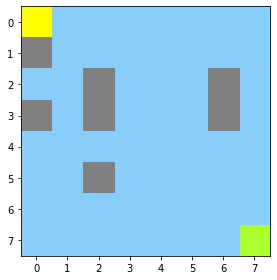

In [367]:
render_frozen_lake(s=s, w=w, h=h)

# Value Iteration

### Tune Params

In [398]:
vi_gamma_99 = run_vi(P=P, R=R, gamma=0.99, epsilon=0.01, max_iter=1000)
vi_gamma_98 = run_vi(P=P, R=R, gamma=0.98, epsilon=0.01, max_iter=1000)
vi_gamma_97 = run_vi(P=P, R=R, gamma=0.97, epsilon=0.01, max_iter=1000)
vi_gamma_96 = run_vi(P=P, R=R, gamma=0.96, epsilon=0.01, max_iter=1000)

In [399]:
df_gamma_99 = get_stats(vi_gamma_99)
df_gamma_98 = get_stats(vi_gamma_98)
df_gamma_97 = get_stats(vi_gamma_97)
df_gamma_96 = get_stats(vi_gamma_96)

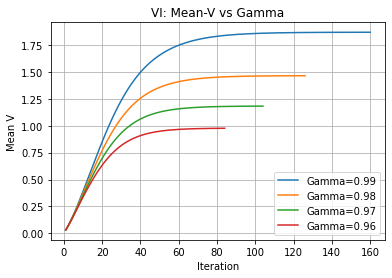

In [400]:
plt.title("VI: Mean-V vs Gamma")
plt.xlabel("Iteration")
plt.ylabel("Mean V") 

plt.plot(df_gamma_99["iteration"], df_gamma_99["mean_v"], label="Gamma=0.99")
plt.plot(df_gamma_98["iteration"], df_gamma_98["mean_v"], label="Gamma=0.98")
plt.plot(df_gamma_97["iteration"], df_gamma_97["mean_v"], label="Gamma=0.97")
plt.plot(df_gamma_96["iteration"], df_gamma_96["mean_v"], label="Gamma=0.96")

plt.grid()
plt.legend()
plt.show()

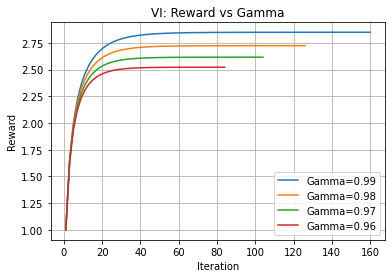

In [401]:
plt.title("VI: Reward vs Gamma")
plt.xlabel("Iteration")
plt.ylabel("Reward") 

plt.plot(df_gamma_99["iteration"], df_gamma_99["reward"], label="Gamma=0.99")
plt.plot(df_gamma_98["iteration"], df_gamma_98["reward"], label="Gamma=0.98")
plt.plot(df_gamma_97["iteration"], df_gamma_97["reward"], label="Gamma=0.97")
plt.plot(df_gamma_96["iteration"], df_gamma_96["reward"], label="Gamma=0.96")

plt.grid()
plt.legend()
plt.show()

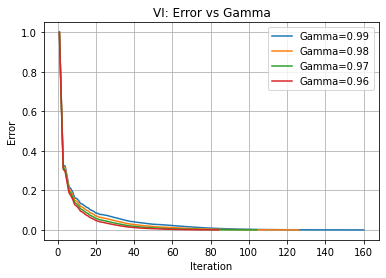

In [402]:
plt.title("VI: Error vs Gamma")
plt.xlabel("Iteration")
plt.ylabel("Error") 

plt.plot(df_gamma_99["iteration"], df_gamma_99["error"], label="Gamma=0.99")
plt.plot(df_gamma_98["iteration"], df_gamma_98["error"], label="Gamma=0.98")
plt.plot(df_gamma_97["iteration"], df_gamma_97["error"], label="Gamma=0.97")
plt.plot(df_gamma_96["iteration"], df_gamma_96["error"], label="Gamma=0.96")

plt.grid()
plt.legend()
plt.show()

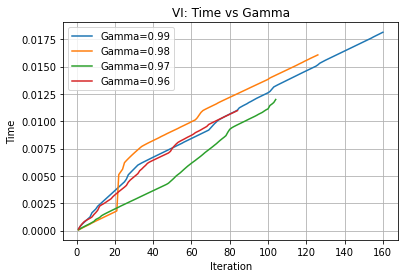

In [403]:
plt.title("VI: Time vs Gamma")
plt.xlabel("Iteration")
plt.ylabel("Time") 

plt.plot(df_gamma_99["iteration"], df_gamma_99["time"], label="Gamma=0.99")
plt.plot(df_gamma_98["iteration"], df_gamma_98["time"], label="Gamma=0.98")
plt.plot(df_gamma_97["iteration"], df_gamma_97["time"], label="Gamma=0.97")
plt.plot(df_gamma_96["iteration"], df_gamma_96["time"], label="Gamma=0.96")

plt.grid()
plt.legend()
plt.show()

- Pick gamma=0.99

In [427]:
vi_epsilon_1    = run_vi(P=P, R=R, gamma=0.99, epsilon=0.1, max_iter=1000)
vi_epsilon_01   = run_vi(P=P, R=R, gamma=0.99, epsilon=0.01, max_iter=1000)
vi_epsilon_001  = run_vi(P=P, R=R, gamma=0.99, epsilon=0.001, max_iter=1000)

In [428]:
df_epsilon_1    = get_stats(vi_epsilon_1)
df_epsilon_01   = get_stats(vi_epsilon_01)
df_epsilon_001  = get_stats(vi_epsilon_001)

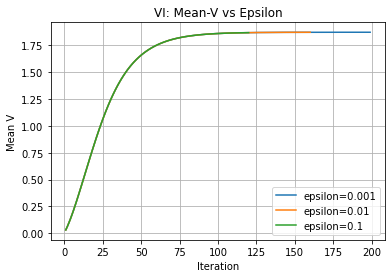

In [429]:
plt.title("VI: Mean-V vs Epsilon")
plt.xlabel("Iteration")
plt.ylabel("Mean V") 


plt.plot(df_epsilon_001["iteration"], df_epsilon_001["mean_v"], label="epsilon=0.001")
plt.plot(df_epsilon_01["iteration"], df_epsilon_01["mean_v"], label="epsilon=0.01")
plt.plot(df_epsilon_1["iteration"], df_epsilon_1["mean_v"], label="epsilon=0.1")


plt.grid()
plt.legend()
plt.show()

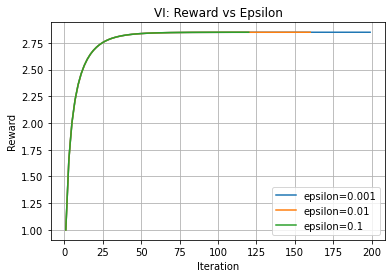

In [431]:
plt.title("VI: Reward vs Epsilon")
plt.xlabel("Iteration")
plt.ylabel("Reward") 


plt.plot(df_epsilon_001["iteration"], df_epsilon_001["reward"], label="epsilon=0.001")
plt.plot(df_epsilon_01["iteration"], df_epsilon_01["reward"], label="epsilon=0.01")
plt.plot(df_epsilon_1["iteration"], df_epsilon_1["reward"], label="epsilon=0.1")


plt.grid()
plt.legend()
plt.show()

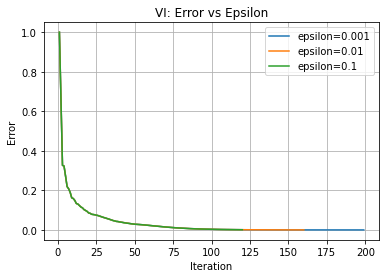

In [430]:
plt.title("VI: Error vs Epsilon")
plt.xlabel("Iteration")
plt.ylabel("Error") 


plt.plot(df_epsilon_001["iteration"], df_epsilon_001["error"], label="epsilon=0.001")
plt.plot(df_epsilon_01["iteration"], df_epsilon_01["error"], label="epsilon=0.01")
plt.plot(df_epsilon_1["iteration"], df_epsilon_1["error"], label="epsilon=0.1")


plt.grid()
plt.legend()
plt.show()

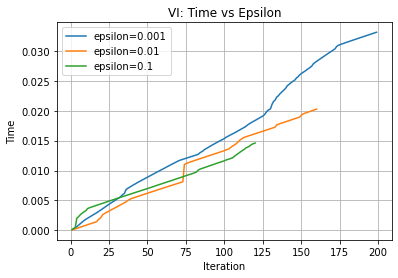

In [433]:
plt.title("VI: Time vs Epsilon")
plt.xlabel("Iteration")
plt.ylabel("Time") 


plt.plot(df_epsilon_001["iteration"], df_epsilon_001["time"], label="epsilon=0.001")
plt.plot(df_epsilon_01["iteration"], df_epsilon_01["time"], label="epsilon=0.01")
plt.plot(df_epsilon_1["iteration"], df_epsilon_1["time"], label="epsilon=0.1")


plt.grid()
plt.legend()
plt.show()

In [372]:
vi = run_vi(P=P, R=R, gamma=0.99, epsilon=0.01, max_iter=1000)

Policy:  (3, 3, 2, 2, 2, 0, 1, 2, 0, 2, 3, 2, 1, 1, 3, 1, 1, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0)
Iterations:  160
CPU time:  0.021268129348754883
Wallclock time : 0.02132415771484375
------------------------------------------------------------------


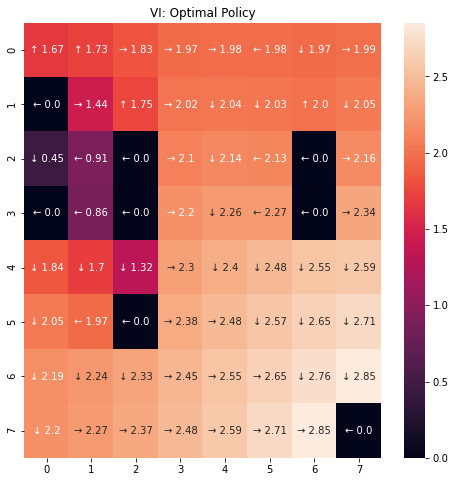

In [374]:
show_policy(vi, w, h, "VI: Optimal Policy")

# Policy Iteration

In [375]:
pi = run_pi(P=P, R=R, gamma=0.99, epsilon=0.01, max_iter=1000)

Policy:  (3, 3, 2, 2, 2, 0, 1, 2, 0, 2, 3, 2, 1, 1, 3, 1, 3, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0)
Iterations:  1000
CPU time:  0.6038088798522949
Wallclock time : 0.6038358211517334
------------------------------------------------------------------


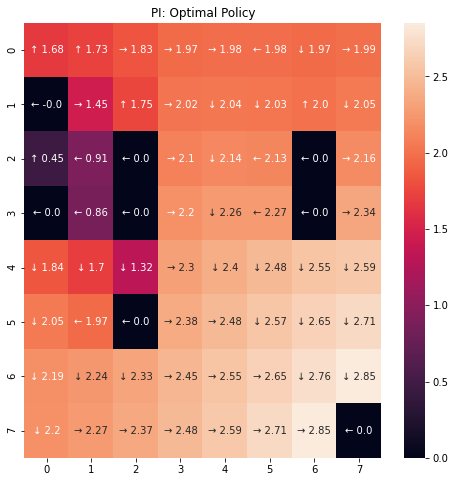

In [376]:
show_policy(pi, w, h, "PI: Optimal Policy")